# **Sapphire Tutorial**

## **Set-Up**
_Please run the following code to ensure that Z3, Sapphire, and other libraries are installed for this tutorial._

In [ ]:
!pip install z3-solver
from z3 import *

!git clone https://github.com/wenkokke/sapphire.git
!pip install -r sapphire/requirements.txt | grep -v 'already satisfied'
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import operator
import tensorflow.keras as keras
from sapphire.sapphire import *

*Note: Make sure to follow along and run **all** of code cell blocks.*

## **A Brief Introduction to Keras [1]**

The neural networks are created using `tensorflow.keras`, a high-level API which builds and trains the NN models.

Building a Neural Network in `tensorflow.keras` consists of 3 stages:
- creating a training and a testing dataset for the neural net,
- creating the neural network `model` (where the number of layes and the activation function is chosen) and compiling it (where the optimiser, loss function, and the metric is chosen), and finally
- training the neural network `model` using the training dataset and testing using the testing dataset

#### **The Training and Testing Datasets**

Whenever a neural network is created, 2 types of datasets are needed, the training dataset, which is often large, on which the neural network gets trained on, and the testing dataset, which is often smaller and consist of new data of the same type as the training set but one that the neural network has not seen before. For example the `MNIST` dataset (images of handwritten digits (`0-9`)) has `60,000` images used for the training dataset, and `10,000` images used for the testing. 

There are loads of datasets out there which are used in machine learning and neural networks such as the `MNIST` or the `iris` datasets (which are cosidered to be the "`Hello World!`" programs of the ML and NN world). 
Some of the most popular "beginner" repositories of datasets are:
- TensorFlow Datasets (`tensorflow_datasets`)
- `sklearn.datasets` 
- `keras.datasets`

CSV datasets can also be loaded in and preprocessed for the use in machine learning and neural networks. 

In [ ]:
mnist = keras.datasets.mnist

(train_mnist_img, train_mnist_labels), (test_mnist_img, test_mnist_labels) = mnist.load_data()

print(train_mnist_img.shape)
plt.figure()
plt.imshow(train_mnist_img[2])
plt.colorbar()
plt.grid(False)
plt.show()

#### **The Neural Network Model**

*Note: The following section covers how to build a neural network model using the Keras features which are supported by Sapphire. For other models please refer to the [TensorFlow Tutorials](https://www.tensorflow.org/tutorials).*

A `model` of the Neural Network is defined by setting the following:
- The type of the neural network e.g. Feedforward Networks (`keras.Sequential`) 
- The layers of the neural network e.g. Fully-Connected Layers (`keras.layers.Dense`), and finally
- The activation function (`'linear'`, `'relu'`, `'sigmoid'`, and `'softmax'`)

Once the `model` is defined, the Neural Network can then be compiled by using the `.compile() `function on the `model` [2]. Here parameters such as:
- `optimizer` - how the NN model is updated based on the loss function and the data it sees:
  - `SGD` (Stochastic gradient descent), 
  - `Adagrad`, 
  - `Adam` (based on adaptive estimation of first-order and second-order moments) [3], and more,
- `loss` - how accurate the model is during trainings:
  - `binary_crossentropy`(a probabilistic loss function, used when there are only two label classes) [4,5], 
  - `sparse_categorical_crossentropy` (another probabilistic loss function, useful for more than two mutually exclusive classes) [4,5], 
  - `mean_squared_error` (a regression loss function, used to compute the mean of squares of errors between labels and predictions) [4,6], and more,
- `metrics` - used for monitoring the training and later the testing steps, evaluating the performance of the model: 
  - `accuracy` shows the fraction of the data that is correctly classified, 
  - `binary_accuracy` calculates how often predictions match binary labels [7], 
  - `sparse_top_k_categorical_accuracy` computes how often integer targets are in the top `K` predictions [7]

can be set. 

In [ ]:
# since the pixel values are between 0 and 255
# these need to be scaled to a range of 0 to 1 before feeding them to the NN
train_mnist_img = train_mnist_img / 255.0
test_mnist_img = test_mnist_img / 255.0

# for the MNIST dataset
# Flatten transforms the 2D array of images into 1D array
# Dense has 2 layers, first with 128 neurons, and the second 10 (the ouput later)
# this indicates each of the 10 classes - numbers 0 to 9
# an array where each node contains a score that 
# indicates the current image belongs to one of the 10 classes
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Training and Testing**

Finally once the Neural Network `model` is compiled, it can be trained by calling the `.fit()` function on the `model`. Here the training data and a number of epochs is supplied to the `.fit()` function in order to train the `model`. 
- epochs - define how many times the NN `model` will pass over a dataset [2] e.g. 5 means that the neural network will go through the data set 5 times.



In [ ]:
model.fit(train_mnist_img,train_mnist_labels, epochs=10)

Once the `model` is trained, it can then be tested on new data to see how it performs. It can also be used to make predictions about certain images within the dataset.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_mnist_img, test_mnist_labels, verbose=2)
print('\n Test Loss: ', test_loss)
print('\n Test Accuracy: ', test_accuracy)

For another example, which is a similar problem to `MNIST`, see the [Basic classification: Classify images of clothing](https://www.tensorflow.org/tutorials/keras/classification) tutorial.

### **Epsilon-Ball Verification**

A neural network `model` can be easily checked and verified on "whole" inputs, but what is more important is how robust the `model` is when the input has some small error/disortion added to it.

How can this be checked? By using what is known as the "`epsilon-ball`" verification, where `epsilon` means some small number. 

Let's look back to the `MNIST` dataset:

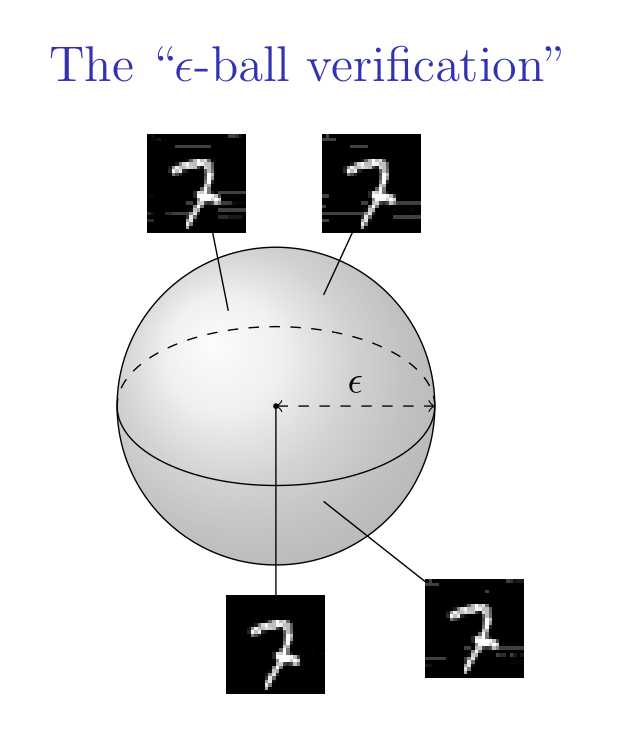

(Thanks to Rob Stewart for the above image)

The `epsilon` is used when there are distorions in the input images, when the Euclidean Distance is greater than that of the "whole" image.

# **The Sapphire Library**

Sapphire is a Python library that has been developped by Heriot-Watt's Lab for AI and Verification. It translates TensorFlow Neural Network models into Z3 and verifies them by calling the Z3 SMT-solver. [8] 

Sapphire currently supports feedforward neural networks (where the inputs are fed forward through the network, and there are no cycles in the network).

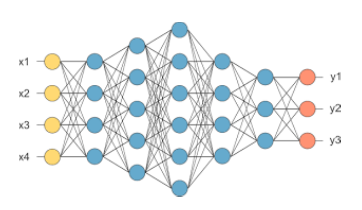

### **Translating the Neural Network `model` into Z3**

The translation is done by the `NN()` function in Sapphire which takes in the neural network description, the `model`, and outputs two vectors of Z3 elements (which are Python lists).

The first, `X`, is a list of Z3 variables e.g. `Reals('x1 x2 x3 x4...')`, one for each input to the neural network, while the second, `Y`, is a list of Z3 expressions, one for each output to the neural network, where each output is described just by using simple multiplication, addition and some additional calculations/checks for approximating the activation functions.  

The activation functions need to be approximated, as they cannot be represented in non-linear arithmetic or in linear arithmetic, and hence the SMT-solver, which can solve either linear real arithmetic (`SolverFor(‘LRA’)`) or nonlinear real arithmetic (`SolverFor(‘NRA’)`), would not be able to work with them. So they need to be linearized. 

In Sapphire this is done by applying "line segments" on the function:

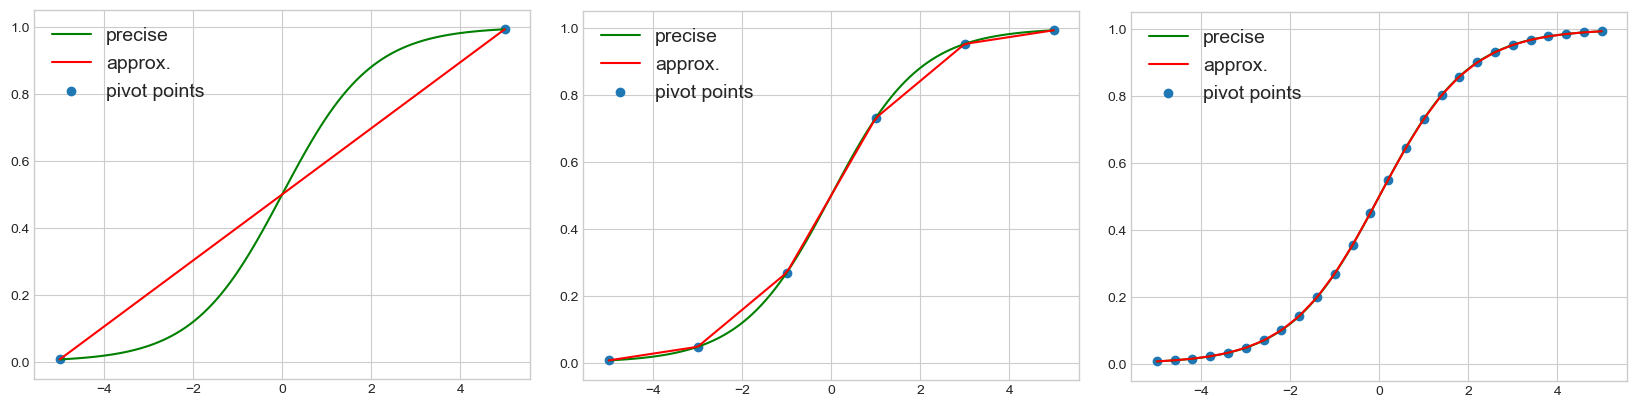 

Note: although having more line segments approximates the function better, the worse the performance gets.

#### **Single-Layer Feedforward Neural Network**

A single layer feedforward neural network is made out of:
- a matrix, `W`, for weights
- a vector, `b`, for biases, 
- and an activation function, `f`, e.g. Sigmoid, ReLU, SoftMax etc.

Given some input vector, `X`, the neural network is evaluated on that input and the output, `Y`, is obtained by simply computing `Y = f(XW+b)`. Here the input vector and the matrix of weights are multipled together using matrix multiplication. Then the bias is added to that using vector addition, followed by applying the activation function on the obtained sum.

For any given 2 matrices, `A` and `B`, every field in their matrix product can be described as `C = AB` just by using regular multiplication and addition. Similiarly for vector addition, `c_i = a_i + b_i`, and for applying activation functions e.g. the ReLU activation function is applied to each field in the vector separeately. 


#### **The `NN()` Function [2]**

Let's take a look into the code:

Here 2 lists are defined, one for the inputs, and the other for all of the hidden layers of the network. This includes the output later which can be taken from H and returned at the end.
```
def NN(model):
    X = None
    H = []
```

Next, looping over each layer in the model, get all of the information that is stored in the Keras model of the neural network, the weights.

Sometimes what happens is some layers have no weights, so these layers just need to be skipped. For any other layer get its configuration, shape, weights, and biases:

```
for layer in model.layers:
        params = layer.get_weights()
        # print(params)

        # Ignore layers without weights
        if len(params) <= 0: continue

        config = layer.get_config()
        rows, cols = params[0].shape
        weights = params[0].tolist()
        biases = params[1].tolist()
```

If the current layer is the first layer, then initialise the input vector with a bunch of Real variables for Z3. These will serve as the inputs to the network:

```
        # Initialise input vector:
        if X is None:
            X = [ Real('x%s' % i) for i in range(rows) ]
            H.append(X)
```

In the code below `I` refers to the inputs of each of the hidden layers. The weight matrix, is translated into Z3 values by applying the `RealVal` function (which was shown in the Z3 tutorial of this masterclass) to each of the values in the matrix. And the same is done for the biases. 

Next the output is computed using vector addition and the vector-matrix product, like in the `(XW+b)` part of the equation above, followed by applying the activation function on its sum. Once this is completed it is added to the list of hidden layer outputs.

Finally, after looping through all of the layers in the model, take the last element of the hidden layer list, which is the output of the whole neural network model and return it and the input vector list from the function.

```
        # Compute output from input and weights:
        I = H[-1]
        W = map(partial(map, RealVal), weights)
        B = map(RealVal, biases)
        O = vecadd(vecmatprod(I, W), B)
        O = activation(config['activation'], O)
        H.append(O)

    Y = H.pop()
    return (X, Y)
```

These 2 lists, `X` (the NN inputs) and `Y` (the NN output), can then be used with the Z3 `Solver()` in order to verify the neural network. This works for any feedforward neural network model, however if the network gets too big then Z3 will take an unfeasible amount of time to solve the query.

### **AND-Gate Neural Network Example**

The following example shows and explains how to use Sapphire on a simple AND-gate Neural Network [8].

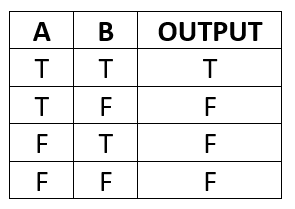

Consider the above AND-Gate table. It can easily be represented as a neural network (2 inputs, 1 output), where the truth, `T`, values are represented as `1`, and the false, `F`, values as `0`, and can be easily verified with Z3 by inserting `(1,1)`, `(1,0)`, `(0,1)`, and `(0,0)` as the verification conditions. 

But how robust is it when the input is within some `epsilon` of `0` or `1` e.g. `0.0000322` or `0.9999887`. The AND-gate neural network should still work as expected. 

Firstly the data for training the Neural Network needs to be created:

`andy()` - defines the perfect classifier that the Neural Network should learn. 

`mk_andy_data()` - creates loads of binary AND-gate data that is used for training of the Neural Network.

In [ ]:
def andy(X, epsilon):
    """Boolean AND gate lifted to floating point numbers."""
    return float(all(1-epsilon <= x and x <= 1+epsilon for x in X))

def mk_andy_data(epsilon):
    """Create data for training an AND gate."""
    T = np.linspace(1-epsilon, 1+epsilon, num=100)
    F = np.linspace(0-epsilon, 0+epsilon, num=100)
    D = np.append(T, F)
    X = np.array([ (x1, x2) for x1 in D for x2 in D ])
    Y = np.array(list(map(partial(andy, epsilon=epsilon), X)))
    return (X, Y)

Next the Neural Network is defined:

`mk_andy_model()` - builds, compiles, and trains a Keras Neural Network `model` that is based on the AND-gate. The architecture of `model` can be changed per Neural Nework needs.

In [ ]:
def mk_andy_model(epsilon=0.25):
    x_train, y_train = mk_andy_data(epsilon=epsilon)
    model = keras.Sequential([
        keras.layers.Dense(1, activation='sigmoid', input_shape=(2,)),
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10)
    return model

The AND-gate is now defined, and can be translated by Sapphire into Z3 in order to verify if it is robust or not. Note here that robust means that if the input is within some `epsilon` of a `0.0` or `1.0` then the gate still works.

`test_andy()` - Trains the model first by calling the `mk_andy_model()`, then defines verification conditions helper functions `Truthy` and `Falsey` (i.e. if the input is within some Epsilon of 1 and within some Epsilon of 0 check if the gate still works) which are used for the verification of the Neural Network, converts the model into Z3 using the `NN()` function from Sapphire, then adds verification conditions to the model, and checks its satisfiability.

In [ ]:
def test_andy():
    """
    Test using a model which approximates the AND gate, and a robustness
    constraint which tests all values in an epsilon-square around the four
    golden standard inputs---(1,1), (1,0), (0,1), and (0,0).
    """

    # Train network
    model = mk_andy_model(epsilon=0.25)

    # Verify network
    Epsilon = 0.2
    
    def Truthy(x):
        return And([1 - Epsilon <= x, x <= 1 + Epsilon])

    def Falsey(x):
        return And([0 - Epsilon <= x, x <= 0 + Epsilon])

    X, Y = NN(model)
    
    s = SolverFor('LRA') # this sets the Solver to use the Linear Real Arithmetic

    # these verification conditions check to see if 
    # a counter-example to these properties exists
    
    s.add(And([Truthy(X[0]), Truthy(X[1]), Not(Y[0] > 0.5)]))
    s.add(And([Falsey(X[0]), Truthy(X[1]), Not(Y[0] < 0.5)]))
    s.add(And([Truthy(X[0]), Falsey(X[1]), Not(Y[0] < 0.5)]))
    s.add(And([Falsey(X[0]), Falsey(X[1]), Not(Y[0] < 0.5)]))

    # a counter example does not exist so it is unsatisfiable - and so the neural network is verified 
    assert s.check() == unsat # returns true if unsatisfiable, raises an AssertionError otherwise

Run the test below.

In [ ]:
test_andy()

Epoch 1/10
1250/1250 [==============================] - 1s 755us/step - loss: 0.6060 - accuracy: 0.6862
Epoch 2/10
1250/1250 [==============================] - 1s 746us/step - loss: 0.4345 - accuracy: 0.9200
Epoch 3/10
1250/1250 [==============================] - 1s 746us/step - loss: 0.3376 - accuracy: 0.9783
Epoch 4/10
1250/1250 [==============================] - 1s 759us/step - loss: 0.2715 - accuracy: 0.9892
Epoch 5/10
1250/1250 [==============================] - 1s 752us/step - loss: 0.2234 - accuracy: 0.9933
Epoch 6/10
1250/1250 [==============================] - 1s 781us/step - loss: 0.1875 - accuracy: 0.9954
Epoch 7/10
1250/1250 [==============================] - 1s 761us/step - loss: 0.1598 - accuracy: 0.9963
Epoch 8/10
1250/1250 [==============================] - 1s 831us/step - loss: 0.1379 - accuracy: 0.9972
Epoch 9/10
1250/1250 [==============================] - 1s 783us/step - loss: 0.1204 - accuracy: 0.9975
Epoch 10/10
1250/1250 [==============================] - 1s 764u

### **OR-Gate Neural Network Exercise**

Given the above AND-Gate example, complete the following OR-Gate exercise.

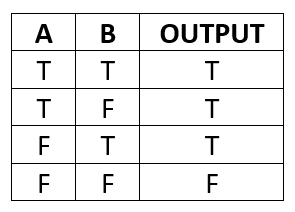

Hint: For the OR-Gate, the data for the training of the Neural Network and the verification conditions need to be changed. The model remains the same (2 inputs, 1 output). 
- The training data should be made for _any_ `1` minus `epsilon` less than or equal to `x` _and_ `x` less than or equal to `1` plus `epsilon`. 
- the verification conditions need to be flipped for the following inputs:
  - `true` and `false`
  - `false` and `true`

*Note: Make sure to run **all** of code cell blocks.*

Create the OR-Gate training data:

In [ ]:
# define a perfect ory classifier

def ory(X, epsilon):
    return None

def mk_ory_data(epsilon):
    T = np.linspace(1-epsilon, 1+epsilon, num=100)
    F = np.linspace(0-epsilon, 0+epsilon, num=100)
    D = np.append(T, F)
    X = np.array([ (x1, x2) for x1 in D for x2 in D ])
    
    # call the new function 
    Y = None
    return (X, Y)

The OR-Gate `model` (no need to change this since it is the same as the AND-gate `model`):

In [ ]:
# OR-Gate model

def mk_ory_model(epsilon=0.25):
    x_train, y_train = mk_ory_data(epsilon=epsilon)

    model = keras.Sequential([
        keras.layers.Dense(1, activation='sigmoid', input_shape=(2,)),
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10)
    return model

Create the OR-Gate test:

In [ ]:
# OR-Gate Test

def test_ory():

    # Train network
    model = mk_ory_model(epsilon=0.25)

    # Verify network
    Epsilon = 0.2
    
    def Truthy(x):
        return And([1 - Epsilon <= x, x <= 1 + Epsilon])

    def Falsey(x):
        return And([0 - Epsilon <= x, x <= 0 + Epsilon])

    # call the NN() function here on the model
    
    # create a solver and set it to use the Linear Real Arithmetic
    
    # add the verification conditions

    assert s.check() == unsat

Run the OR-Gate test:

In [ ]:
test_ory()

### **Iris Neural Network Exercise - Challenging**

The iris dataset is one of the most famous datasets, and is often used as the "`Hello World!`" classification example in machine learning. It has been created by R.A. Fisher in 1936, and donated to the UCI Machine Learning Repository by Michael Marshall in 1988 [9].

The dataset contains `150` elements in total, with `3` classes of `50` instances each, where each class refers to the type of the iris plant: 
- `setosa`,
- `versicolor`, and 
- `virginica`

The dataset contains the following features:
- `sepal length (cm)`, 
- `sepal width (cm)`, 
- `petal length (cm)`, and
- `petal width (cm)`

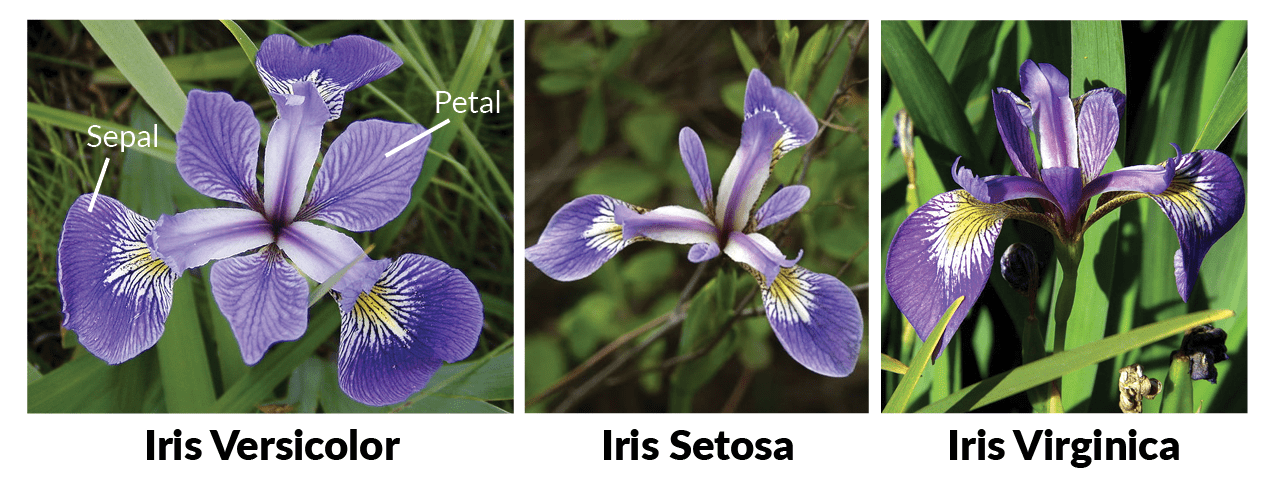
(Iris image taken from [10])

The following exercise will focus on creating a Neural Network model which uses this dataset and later verifying it using Sapphire and Z3 just like in the previous examples. 

**Getting the Iris Dataset**

The iris dataset can be loaded in from `sklearn` datasets: 

In [ ]:
from sklearn.datasets import load_iris # the iris data set 
from sklearn.model_selection import train_test_split # method for splitting up the dataset

def get_iris_dataset():
  # get the dataset
  iris_dataset = load_iris()

  # split the data
  x_train, x_test, y_train, y_test = train_test_split(iris_dataset['data'],iris_dataset['target'], random_state=0)
  
  return (x_train, y_train)

**Creating the Neural Network `model`**

Simplest `model`:
- 4 features = 4 inputs
- 3 classes = 3 outputs

In [ ]:
# neural network model for the iris dataset 
def mk_iris_model():
    x_train, y_train = get_iris_dataset()

    # Task 1a - modify the model by adding a hidden layer to it

    """model = keras.Sequential([
        keras.layers.Dense(3, activation='linear', input_shape=(4,)),
        keras.layers.Activation('softmax')
    ])"""

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100) # change epochs
    return model

**Verification Conditions**

Looking into the data:

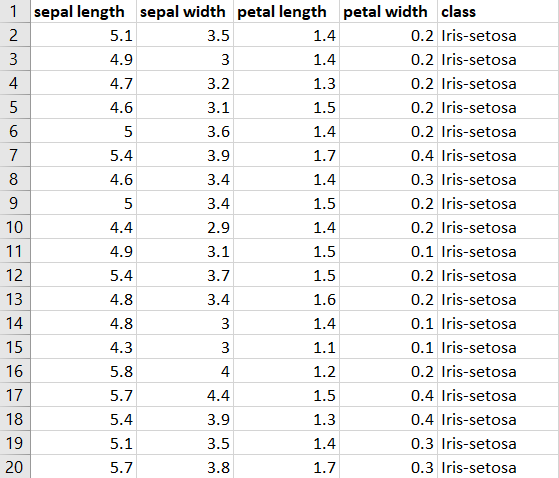

(Snippet of the Iris Dataset [9])

A flower is classed as an iris setosa: 
- if the petal width has a value that is less than 1.0
- if the petal length has a value that is less than 2.0
- if the sepal length has a value between 4 and 5.8 


In [ ]:
def test_iris():

    # Train network
    model = mk_iris_model()
    model.layers.pop() # remove the softmax layer so we don't have to deal with the 
    # exp anymore

    # iris features
    SepalLength = 0
    SepalWidth = 1
    PetalLength = 2
    PetalWidth = 3

    # iris classes
    # 0 = setosa, 1 = versicolor, 2 = virginica
    Setosa = 0
    Versicolor = 1
    Virginica = 2

    # define verification conditions
    """def IsSetosa(Y):
      return And(Y[Setosa] > Y[Versicolor], Y[Setosa] > Y[Virginica])

    def Between(l, x, u):
      return And([l <= x, x <= u])"""

    # calling sapphire
    X, Y = NN(model)

    # creating a solver
    s = SolverFor('LRA') # this sets the Solver to use the Linear Real Arithmetic

    """s.add(Implies((Or(Between(4.0, X[SepalLength], 5.8),
                      X[PetalLength] < 2.0,
                      X[PetalWidth] < 1.0)), 
                      (Not(IsSetosa(Y)))))"""


    # Task 1b - uncomment the below code and fill out the rest of the verification
    # conditions
    """s.add(And(Or(Between(0.1, X[PetalWidth], 0.49), 
                  Between(0.1, X[PetalLength], 1.9),
                  # write Sepal Width condition here
                  # write Sepal Length condition here
                  Not(IsSetosa(Y))))"""    

    print(s.check())

**Calling the Test Function**

In [ ]:
test_iris()

**Exercises**

Task 1a) Modify the Neural Network `model` by adding a hidden layer to it. *Hint: for the number of neurons start of with `4`, then increase the number by `4` each time. For the activation function try `relu` first then `tanh`. Try also a different number of epochs e.g. `200`, `300`, etc.*

Task 1b) As mentioned iris setosa is a class that is very well separated from the other two. It is firmly known under which conditions a flower is an iris setosa. Consider the following 2 graphs [11]:

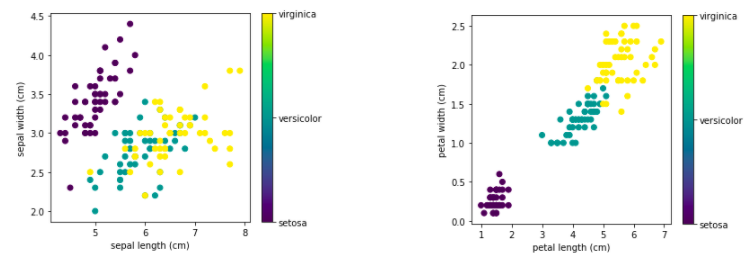

These graphs show the relationships between 2 pairs: `SepalLength, SepalWidth`, and `PetalLength, PetalWidth`. The task here is to infer, from these graphs, the verification conditions that return unsat (i.e. there are no counter examples). *Hint: Use `And` instead of `Or` and the `Between()` function for the verification conditions.*

Task 2) Take the first example from the iris dataset and verify it using epsilon-ball verification. Here assert that the input to the model that is within an epsilon-ball distance of `0.1` classifes as an iris setosa. *Hint: look at the `Truthy` and `Falsey` epsilon conditions from the previous exercises.*

In [ ]:
# Task 2 - Extra Time Exercise

def test_iris_epsilon_ball():

    # Train network
    model = mk_iris_model()
    model.layers.pop() # remove the softmax layer so we don't have to deal with the 
    # exp anymore

    # iris features
    SepalLength = 0
    SepalWidth = 1
    PetalLength = 2
    PetalWidth = 3

    # iris classes
    # 0 = setosa, 1 = versicolor, 2 = virginica
    Setosa = 0
    Versicolor = 1
    Virginica = 2

    # define verification conditions
    def IsSetosa(Y):
      return And(Y[Setosa] > Y[Versicolor], Y[Setosa] > Y[Virginica])
    
    # set the Epsilon variable
    Epsilon = None

     # EpsilonPoint is similar to how the Truthy and Falsey conditions were defined
     # in the previous exercises, except it uses 2 paramters instead of 1
    def EpsilonPoint(x, y):
      return And([x - Epsilon <= y, y <= x + Epsilon])

    # calling sapphire
    X, Y = NN(model)

    # creating a solver
    s = SolverFor('LRA') # this sets the Solver to use the Linear Real Arithmetic

    # fill out the remaining verification conditions
    # make sure to uncomment this
    """s.add(And(And(EpsilonPoint(5.1, X[SepalLength]), 
                  # Sepal Width
                  # Petal Length
                  # Petal Width
                  Not(IsSetosa(Y))))"""

    print(s.check())

**Call the Test Function Below**

In [ ]:
# call the epsilon ball test here 

# **References**

*1. 	Basic classification: Classify images of clothing | TensorFlow Core [Internet]. TensorFlow. [cited 2020 Oct 21]. Available from: https://www.tensorflow.org/tutorials/keras/classification*

*2. 	Keras - Model Compilation - Tutorialspoint [Internet]. [cited 2020 Nov 2]. Available from: https://www.tutorialspoint.com/keras/keras_model_compilation.htm*

*3. 	Keras documentation: Adam [Internet]. [cited 2020 Nov 2]. Available from: https://keras.io/api/optimizers/adam/*

*4. 	Keras documentation: Losses [Internet]. [cited 2020 Nov 2]. Available from: https://keras.io/api/losses/*

*5. 	Keras documentation: Probabilistic losses [Internet]. [cited 2020 Nov 2]. Available from: https://keras.io/api/losses/probabilistic_losses/*

*6. 	Keras documentation: Regression losses [Internet]. [cited 2020 Nov 2]. Available from: https://keras.io/api/losses/regression_losses/#meansquarederror-class*

*7. 	Keras documentation: Accuracy metrics [Internet]. [cited 2020 Nov 2]. Available from: https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class*

*8. 	Kokke W. wenkokke/sapphire [Internet]. 2020 [cited 2020 Nov 3]. Available from: https://github.com/wenkokke/sapphire*

*9. 	UCI Machine Learning Repository: Iris Data Set [Internet]. [cited 2020 Nov 11]. Available from: https://archive.ics.uci.edu/ml/datasets/iris*

*10. 	Machine Learning in R for beginners - DataCamp [Internet]. [cited 2020 Nov 15]. Available from: https://www.datacamp.com/community/tutorials/machine-learning-in-r*

*11. Britton J. Classification Basics: Walk-through with the Iris Data Set [Internet]. Medium. 2020 [cited 2020 Nov 21]. Available from: https://towardsdatascience.com/classification-basics-walk-through-with-the-iris-data-set-d46b0331bf82*
